## Select Top 1 molecules that has the specific properties for the task

In [10]:

import os
import re
import datetime
from mordred import Calculator, descriptors
from rdkit import Chem
import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
import sys
import torch
sys.path.append('/home/ianlee/JTVAE/JTVAE/CPU-P3')
from fast_jtnn import *

vocab_path = '/home/ianlee/JTVAE/Ian_train/Vocabulary/smi_vocab-2.txt'
model_path = '/home/ianlee/JTVAE/Ian_train/Train/MODEL-TRAIN-3/model.epoch-39'

# Load vocabulary
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab)

# Initial Step for VAE
vae_model = JTNNVAE(vocab, hidden_size=450, latent_size=32, depthT=3, depthG=20)
vae_model.load_state_dict(torch.load(model_path, map_location='cpu'))
vae_model.cpu()
vae_model.eval()

[02:48:27] WARNING: not removing hydrogen atom without neighbors


JTNNVAE(
  (jtnn): JTNNEncoder(
    (embedding): Embedding(1223, 450)
    (outputNN): Sequential(
      (0): Linear(in_features=900, out_features=450, bias=True)
      (1): ReLU()
    )
    (GRU): GraphGRU(
      (W_z): Linear(in_features=900, out_features=450, bias=True)
      (W_r): Linear(in_features=450, out_features=450, bias=False)
      (U_r): Linear(in_features=450, out_features=450, bias=True)
      (W_h): Linear(in_features=900, out_features=450, bias=True)
    )
  )
  (decoder): JTNNDecoder(
    (embedding): Embedding(1223, 450)
    (W_z): Linear(in_features=900, out_features=450, bias=True)
    (U_r): Linear(in_features=450, out_features=450, bias=False)
    (W_r): Linear(in_features=450, out_features=450, bias=True)
    (W_h): Linear(in_features=900, out_features=450, bias=True)
    (W): Linear(in_features=466, out_features=450, bias=True)
    (U): Linear(in_features=466, out_features=450, bias=True)
    (U_i): Linear(in_features=900, out_features=450, bias=True)
    (W_o)

In [11]:
today = datetime.date.today().strftime("%Y%m%d")

#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['PSO', 'ABC']
methods = ['PSO/round6', 'PSO/round7', 'PSO/round8', 'PSO/round9',  'PSO/round10']
methods = ['BO/round1', 'BO/round2', 'BO/round3', 'BO/round4','BO/round5','BO/round6', 'BO/round7', 'BO/round8', 'BO/round9',  'BO/round10']
methods = ['Random/round1', 'Random/round2', 'Random/round3', 'Random/round4', 'Random/round5','Random/round6', 'Random/round7', 'Random/round8', 'Random/round9', 'Random/round10']
methods = ['Random/round8']
subfolder = 'c4'

for method in methods:
    print(f"Processing {method} method...")
    folder_path_cn = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/1_Preprocessing_for_Analysis/{method}/{subfolder}'  # 取得當前工作目錄
    folder_list = []

    for item in os.listdir(folder_path_cn):
        if os.path.isdir(os.path.join(folder_path_cn, item)) and item.startswith("Result"):
            folder_list.append(item)

    data = []
    for folder_name in folder_list:
        folder_path = os.path.join(folder_path_cn, folder_name)
        if os.path.exists(folder_path):
            file_list = [file for file in os.listdir(folder_path) if '.sh.o' in file]
            for file in file_list:
                print(f'Processing {file}')
                file_path = os.path.join(folder_path, file)
                with open(file_path, 'r') as f:
                    file_content = f.read()
                parts = file_content.split('\n\n')
                iteration_details, rank_details = parts[-2], parts[-1]
                fitness_list = re.findall('Fitness: ([\de\.\+\-]+)', rank_details)
                fitness_list = list(map(float, fitness_list))
                ranks = rank_details.split("-------------------------")
                #print(ranks)
                #read in every data that has rank 1-10
                best = 0
                for i in range(1):
                    #best_fitness_index = fitness_list.index(fitness_list[i])
                    rank_data = ranks[i].split('\n')
                    rank_data = [line.strip() for line in rank_data if line]
                    file_data = {
                        "Folder Name": folder_name,
                        "Smiles": rank_data[1].split(": ")[1].strip(),
                        "Fitness": (rank_data[9].split(": ")[1].strip()).split(",")[0].strip(),
                        "Reagent1_(ul)": rank_data[3].split(": ")[1].strip(),
                        "Reagent2_(ul)": rank_data[4].split(": ")[1].strip(),
                        "Reagent3_(ul)": rank_data[5].split(": ")[1].strip(),
                        "Reagent4_(ul)": rank_data[6].split(": ")[1].strip(),
                        "lab_code": rank_data[7].split(": ")[1].strip(),
                        "crystal_size": rank_data[9].split(": ")[1].strip()}
                    try:
                        vae_model.encode_latent_mean([file_data['Smiles']])
                        calc = Calculator(descriptors, ignore_3D=True)
                        smiles = (file_data['Smiles'])
                        mols = Chem.MolFromSmiles(smiles)
                        mordred_data = calc.pandas([mols])
                        mordred_data = mordred_data.dropna(axis='columns')
                        numeric_cols = mordred_data.select_dtypes(exclude='number')
                        mordred_data.drop(numeric_cols, axis=1, inplace=True)
                        #print(mordred_data.shape)
                        # 檢查每個列是否存在於 DataFrame 中
                        columns_exist = all(item in mordred_data.columns for item in ["ATSC5v", "AATSC5Z", "MATS8se"])

                        if columns_exist:
                            if best < 1:
                                data.append(file_data)
                                best = 1
                    except:
                        print(f"Error: {file_data['Smiles']}", "encode falied")      
                              
                #need to calculate the Mordred descriptors
        else:
            print(f"Folder '{folder_name}' does not exist.")

    df = pd.DataFrame(data)
    # modred feature calculating
    calc = Calculator(descriptors, ignore_3D=True)
    smiles_list = list(df['Smiles'])
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    mordred_df = calc.pandas(mols)
    
    cols_to_convert = ['ATSC5v', 'AATSC5Z', 'MATS8se']
    
    import pandas as pd
    df = pd.concat((df, mordred_df['ATSC5v'] ,mordred_df['AATSC5Z'], mordred_df['MATS8se']), axis=1)
    
    df[["crystal_size", "crystal_size_Std"]] = df["crystal_size"].str.split(",", expand=True).astype(float)
    df["Fitness"] = df["Fitness"].astype(float)  # 將 "Fitness" 欄位轉換為浮點數
    df = df.sort_values(by='Fitness', ascending=False)  # 根據 Fitness 值降序排序
    df.reset_index(drop=True, inplace=True)  # 重新設定索引
    df = df[['Folder Name', 'Smiles', 'Fitness', 'ATSC5v', 'AATSC5Z', 
            'MATS8se', 'Reagent1_(ul)', 'Reagent2_(ul)', 'Reagent3_(ul)', 'Reagent4_(ul)', 'lab_code',
            'crystal_size', 'crystal_size_Std']]
    df.dropna()
    
    if len(df)>10:
        #keep the top 10 rows
        df = df.head(10)
    df.to_csv(os.path.join(folder_path_cn, f"{today}pvk_Report.csv"), index=False)
    print(f"CSV file '{today}pvk_Report.csv' has been created.")

    # 找到重复的文件夹名
    duplicates = df[df.duplicated('Smiles')]
    print('Duplicate Smiles:',duplicates['Smiles'])

Processing Random/round8 method...
Processing tmp.sh.o3951872


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

Processing tmp.sh.o3951873



100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

Processing tmp.sh.o3951874



100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


Processing tmp.sh.o3951875


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

Processing tmp.sh.o3951876



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Processing tmp.sh.o3951877


100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


Processing tmp.sh.o3951878


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

Processing tmp.sh.o3951879



100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Processing tmp.sh.o3951880


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Processing tmp.sh.o3951881


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Processing tmp.sh.o3951882


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Processing tmp.sh.o3951883


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Processing tmp.sh.o3951884


100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Processing tmp.sh.o3951885


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Processing tmp.sh.o3951886


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Processing tmp.sh.o3951887


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Processing tmp.sh.o3951888


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Processing tmp.sh.o3951889


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

Processing tmp.sh.o3951890



100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Processing tmp.sh.o3951891


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

Processing tmp.sh.o3951932



100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Processing tmp.sh.o3951933


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Processing tmp.sh.o3951934


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Processing tmp.sh.o3951935


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Processing tmp.sh.o3951936


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

Processing tmp.sh.o3951937



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Processing tmp.sh.o3951938


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Processing tmp.sh.o3951939



100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

Processing tmp.sh.o3951940



100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

Processing tmp.sh.o3951941



100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


Processing tmp.sh.o3951942


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

Processing tmp.sh.o3951943



100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

Processing tmp.sh.o3951944



100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

Processing tmp.sh.o3951945



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

Processing tmp.sh.o3951946



100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Processing tmp.sh.o3951947


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

Processing tmp.sh.o3951948



100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


Processing tmp.sh.o3951949


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

Processing tmp.sh.o3951950



100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

Processing tmp.sh.o3951951
Error: CC(=O)C(NC(=O)C1NCCS1)C(=O)Cc1sc(=O)c2csc(=O)n2c1C encode falied



[02:49:11] Can't kekulize mol.  Unkekulized atoms: 15 19 25
100%|██████████| 20/20 [00:01<00:00, 16.81it/s]


CSV file '20250725pvk_Report.csv' has been created.
Duplicate Smiles: Series([], Name: Smiles, dtype: object)


# 計算真實值與預測值之間的差別

In [12]:
# from mordred import Calculator, descriptors
from sklearn.ensemble import RandomForestRegressor
# from rdkit.Chem import PandasTools
import pickle

In [13]:
def pvk_crystal_predict(df: pd.DataFrame, 
                        pvk_rfr: RandomForestRegressor, 
                        # pvk_rfc: RandomForestClassifier,
                        ):
    # calc = Calculator(descriptors)
    
    # # mored feature creating
    # esol_data = pd.DataFrame(df['SMILES'])
    # PandasTools.AddMoleculeColumnToFrame(esol_data, smilesCol='SMILES')
    # mordred_data = calc.pandas(esol_data['ROMol'])
    # mordred_data = mordred_data.dropna(axis='columns')
    # numeric_cols = mordred_data.select_dtypes(exclude='number')
    # mordred_data.drop(numeric_cols, axis=1, inplace=True)

    # # processing feature creating
    # try:
    #     df = df.drop("SMILES", axis=1)
    # except:
    #     pass

    # # combined two data
    # df = df.join(mordred_data)

    # scroe predict
    pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','ATSC5v', 'AATSC5Z', 'MATS8se']
    # pvk_score_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','ATSC5v','ATSC5pe']
    df_size = df[pvk_size_feature_list]
    # df_score = df[pvk_score_feature_list]

    # return pvk_rfr.predict(df_size), pvk_rfc.predict(df_score), df[pvk_size_feature_list], df[pvk_score_feature_list]
    return pvk_rfr.predict(df_size), df[pvk_size_feature_list]


In [14]:
size_model_path = '/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Ground_Truth_Model/pvkadditives/pvk_rfr_size.pkl'

with open(size_model_path, 'rb') as f:
    rf_regressor = pickle.load(f)

In [15]:
rf_regressor.feature_names_in_

array(['Reagent1 (ul)', 'Reagent2 (ul)', 'Reagent3 (ul)', 'Reagent4 (ul)',
       'lab_code', 'ATSC5v', 'AATSC5Z', 'MATS8se'], dtype=object)

In [16]:
#葉子點數計算
leaf_counts = [Estimator.get_n_leaves() for Estimator in rf_regressor]
mean_leaves = np.mean(leaf_counts)
print(mean_leaves)

106.01


In [17]:
inital_csv = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/0_Create_Surrogate_Model/cycle0_new.csv')
size_array = inital_csv['crystal_size']
criteria = np.percentile(size_array, 100)
print(criteria)
size_array.max(), size_array.mean() 

1.6616891335497823


(1.6616891335497823, 0.6987617853408751)

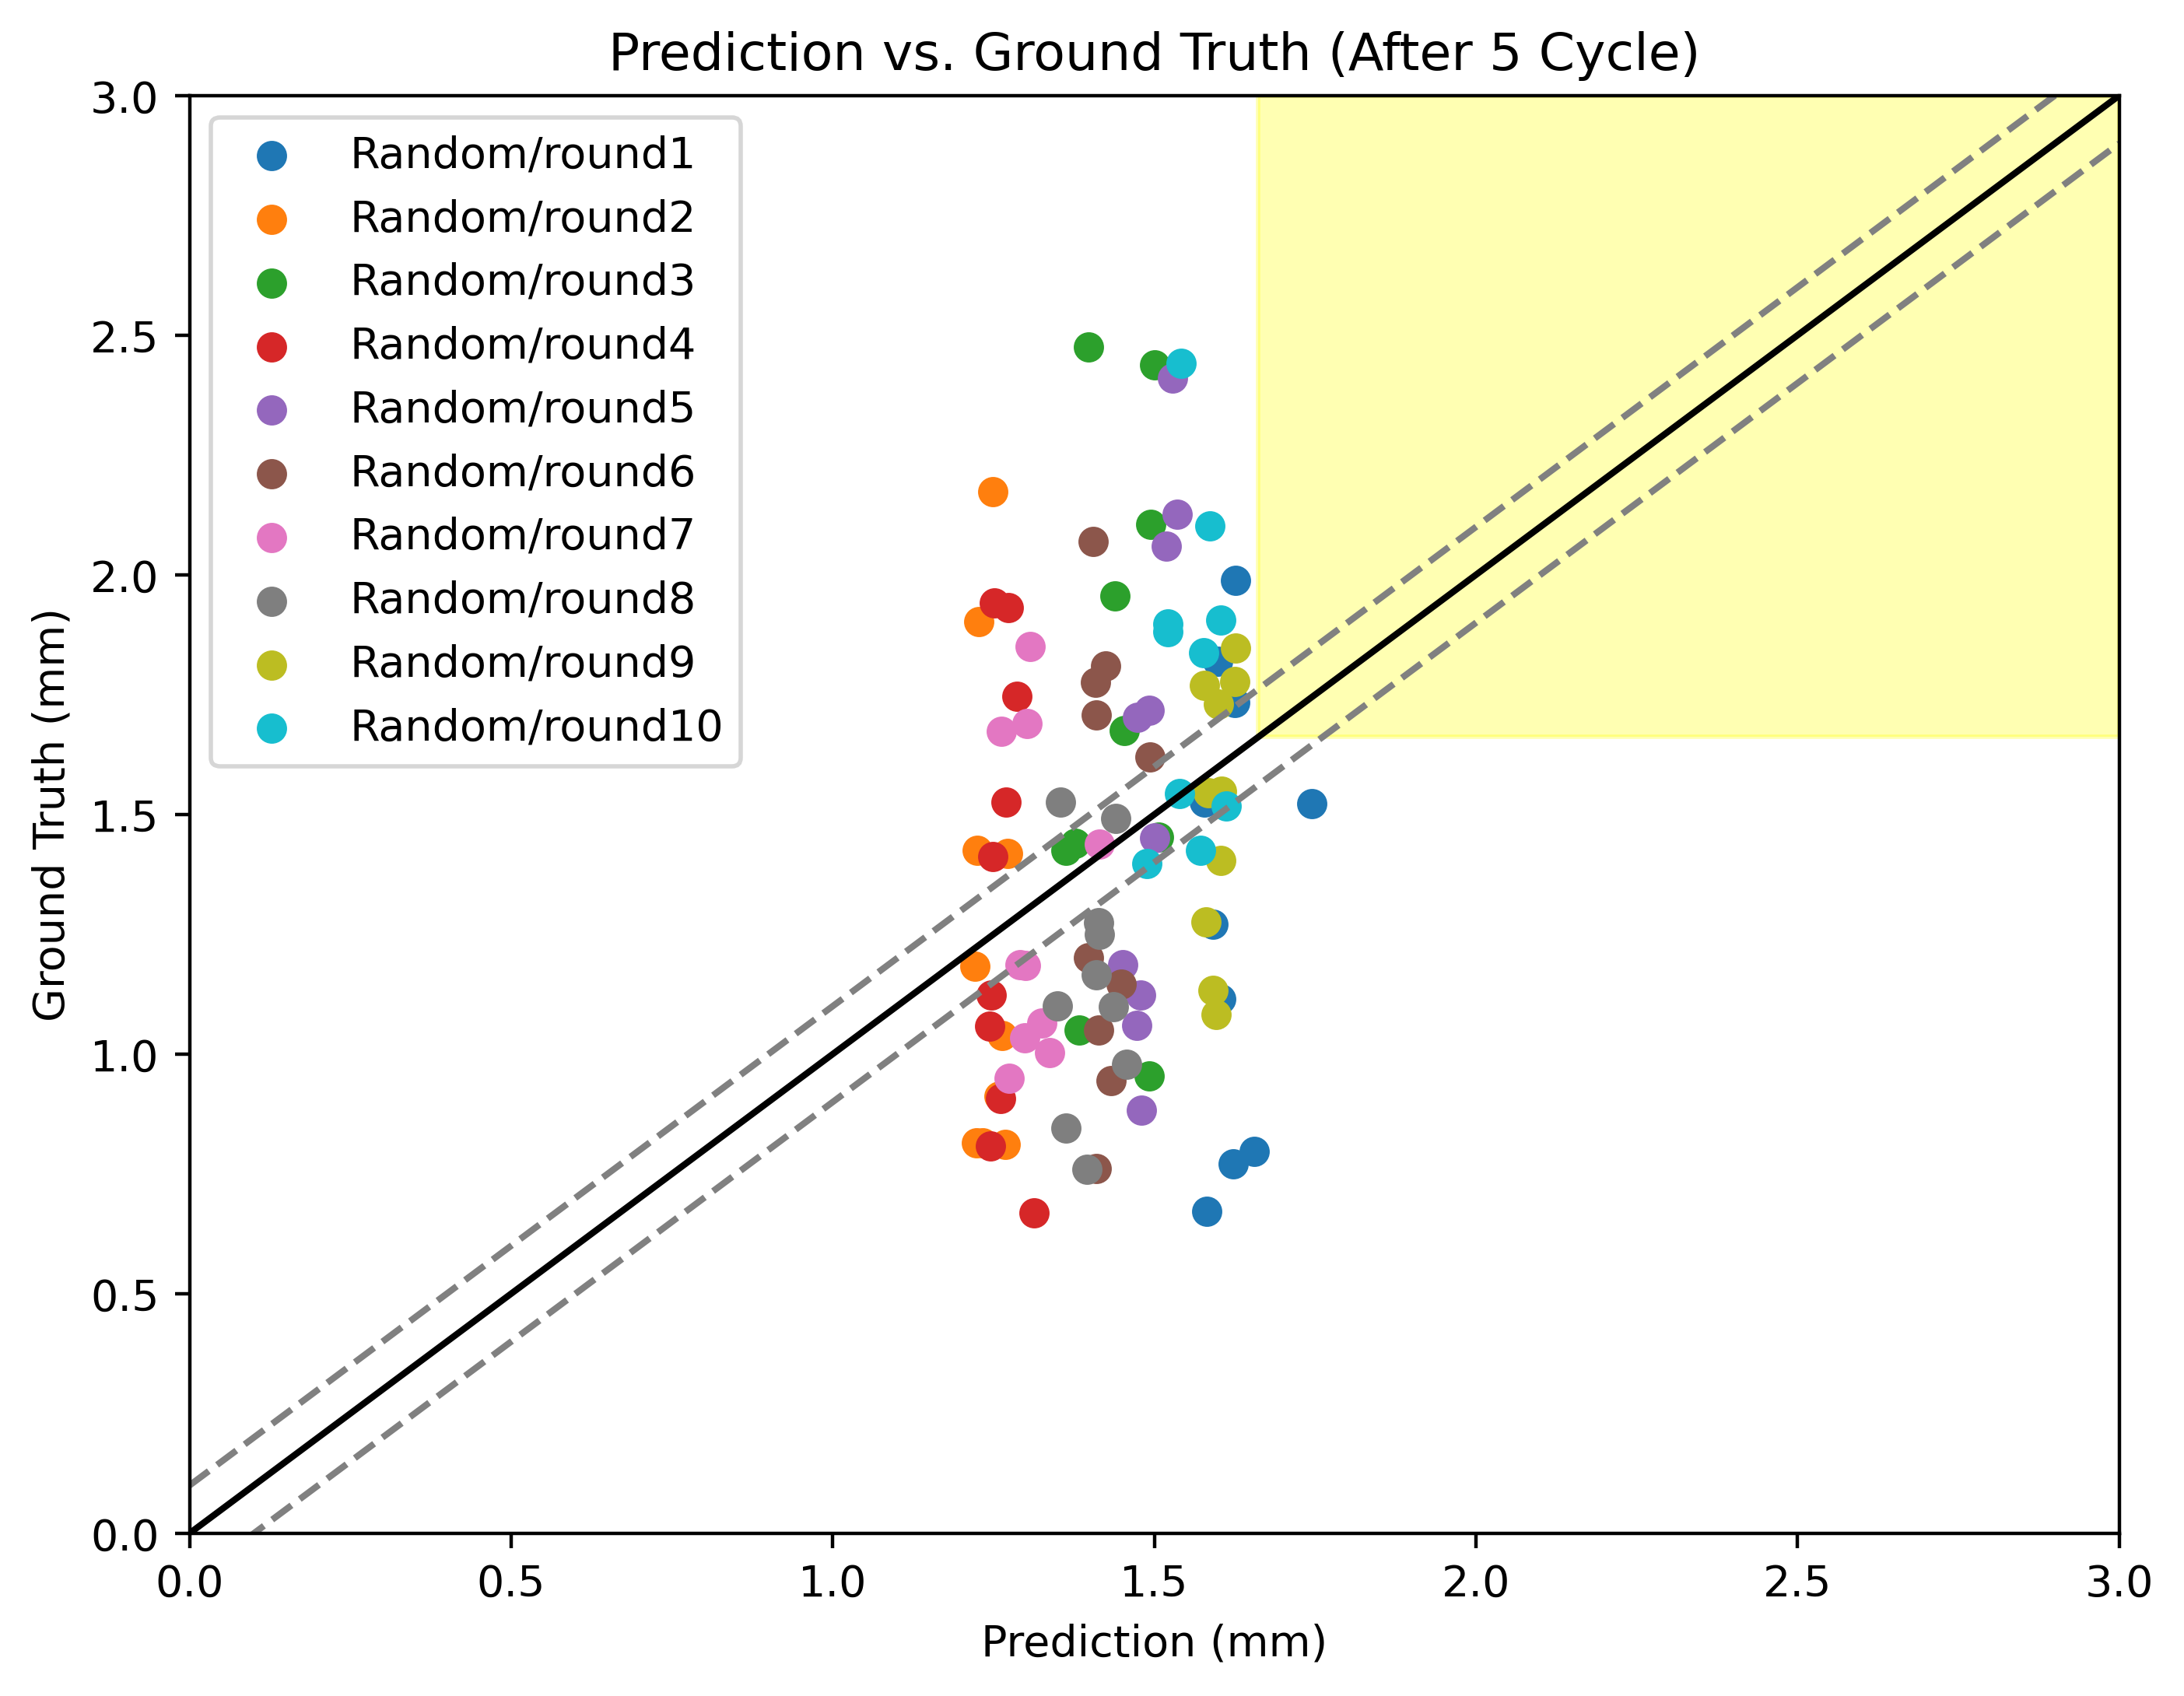

In [18]:
"""
目前對如何評價模型的效果還不是很確定，初步想法是在真實直上要很好並且希望模型的預測值跟實際值可以夠準
第一件事情：看找到的ground truth的平均 第二件事情：看模型的預測值跟ground truth的差距 怎麼樣平衡兩件事情
目前圖中的結果來說我們在margin範圍內預測值的比例有多高 可以先統計 並比較這些預測值內的平均值
但同時也要看誰能夠找到最好的分子 假設有人總有辦法在好多個cycle內都找到離群的優值 那我覺得這樣也是不錯
"""
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['PSO','ABC']
methods = ['PSO/round6', 'PSO/round7', 'PSO/round8', 'PSO/round9',  'PSO/round10']
methods = ['Random/round1', 'Random/round2', 'Random/round3', 'Random/round4', 'Random/round5','Random/round6', 'Random/round7', 'Random/round8', 'Random/round9', 'Random/round10']
subfolder = 'c4'
today = datetime.date.today().strftime("%Y%m%d")

folder_path_cn = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Pvk_additives/1_Preprocessing_for_Analysis/SA/{subfolder}'  # 取得當前工作目錄

#methods = ['ABC', 'GA', 'PSO', 'SA']
#methods = ['ABC/10_iter']
colors = [
    "#1f77b4",  # 藍
    "#ff7f0e",  # 橙
    "#2ca02c",  # 綠
    "#d62728",  # 紅
    "#9467bd",  # 紫
    "#8c564b",  # 棕
    "#e377c2",  # 粉
    "#7f7f7f",  # 灰
    "#bcbd22",  # 橄欖
    "#17becf",  # 青
]


#colors = ['#EE6352']
domain_max, domain_min = 3.0, 0.0
#domain_max, domain_min = 2.0, 0.0

plt.figure(figsize=(8, 6), dpi=400)
plt.fill_betweenx([criteria, domain_max], criteria, domain_max, color='yellow', alpha=0.3)
for method, color in zip(methods, colors):
    new_folder_path_cn = folder_path_cn.replace('SA', method)
    file_path = os.path.join(new_folder_path_cn, f'{today}pvk_Report.csv')
    cyclen_pred = pd.read_csv(file_path)
    pvk_size_feature_list = ['Reagent1 (ul)','Reagent2 (ul)','Reagent3 (ul)','Reagent4 (ul)','lab_code','ATSC5v', 'AATSC5Z', 'MATS8se', 'crystal_size']
    cyclen_pred = cyclen_pred.rename(columns={
    'Reagent1_(ul)': 'Reagent1 (ul)',
    'Reagent2_(ul)': 'Reagent2 (ul)',
    'Reagent3_(ul)': 'Reagent3 (ul)',
    'Reagent4_(ul)': 'Reagent4 (ul)', 
})  
    cyclen_pred = cyclen_pred[pvk_size_feature_list]
    size_features = cyclen_pred.apply(pd.to_numeric, errors='coerce')
    size_features_nonull = size_features.dropna()
    # print(cyclen_pred.columns)
    gt_prediction = pvk_crystal_predict(size_features_nonull, rf_regressor)[0]
    
    #save the prediction result to a new csv file
    # 繪製散點圖
    plt.scatter(size_features_nonull['crystal_size'], gt_prediction, color=color, label=method)



# 繪製對角線
x = np.linspace(domain_min, domain_max)
plt.plot(x, x, color='black')

# 設定x軸和y軸的範圍
plt.xlim(domain_min, domain_max)
plt.ylim(domain_min, domain_max)

# 繪製誤差範圍虛線
plt.plot(x, x + 0.1, color='gray', linestyle='dashed')
plt.plot(x, x - 0.1, color='gray', linestyle='dashed')

# 在圖形上添加文字
# plt.text(1.3, 1.8, 'Underestimate', fontsize=12)
# plt.text(1.7, 1.25, 'Overestimate', fontsize=12)
plt.title(f'Prediction vs. Ground Truth (After {int(subfolder[1]) + 1} Cycle)')
plt.xlabel('Prediction (mm)')
plt.ylabel('Ground Truth (mm)')
plt.legend()
plt.show()